In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np
from tqdm import tqdm
import os

2024-08-15 12:48:06.254097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 12:48:06.254232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 12:48:06.374624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data=pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
def has_condn(term,txt):
    if term in txt:
        return 1
    return 0

In [4]:
def process_dataset(data):
    #create 2 more columns labelling them whether right or left cataract
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))

    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))

    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))

    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))

    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))

    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values

    #store the left/right normal image ids in a array
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values

    #store the left/right diabetes image ids
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values

    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    other = np.concatenate((left_other,right_other),axis = 0);

    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

In [5]:
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [6]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

print("Dataset stats::")
print("Normal ::" , len(normal))
print("Cataract ::" , len(cataract))
print("Diabetes ::" , len(diab))
print("Glaucoma ::" , len(glaucoma))
print("Hypertension ::" , len(hyper))
print("Myopia ::" , len(myopia))
print("Age Issues ::" , len(age))
print("Other ::" , len(other))

Dataset stats::
Normal :: 700
Cataract :: 594
Diabetes :: 1818
Glaucoma :: 610
Hypertension :: 374
Myopia :: 479
Age Issues :: 551
Other :: 324


In [7]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images"
image_size=224
labels = []
dataset = []
def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        imgpath = os.path.join(dataset_dir,img);

        #now we try to read the image and resize it accordingly
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);

    return dataset;

In [8]:
# labels
# Normal == 0
# Cataract == 1
# Diabetes == 2
# Glaucoma == 3
# HyperTension == 4
# Myopia == 5
# Age == 6
# Other == 7

In [9]:
dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(hyper,4)
dataset = dataset_generator(myopia,5)
dataset = dataset_generator(age,6)
dataset = dataset_generator(other,7)

len(dataset)

  0%|          | 0/1818 [00:00<?, ?it/s][ WARN:0@26.188] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@26.263] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/50_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@26.276] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/74_left.jpg'): can't open/read file: check file path/integrity
  1%|          | 22/1818 [00:00<00:19, 90.44it/s] [ WARN:0@26.426] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/195_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@26.427] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/201_left

5396

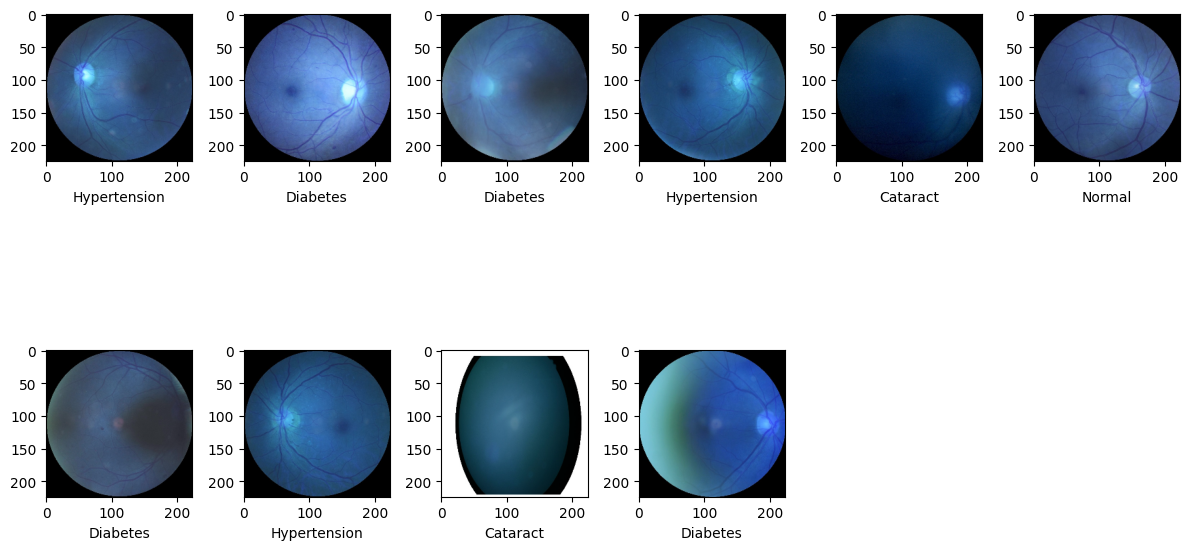

In [10]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]

    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"

    plt.subplot(2,6,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [11]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
y = np.array([i[1] for i in dataset])
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
x_train , x_test , y_train, y_test = train_test_split(x,y, test_size=0.2)
y_train_cat = to_categorical(y_train,num_classes=8)
y_test_cat = to_categorical(y_test,num_classes = 8)


In [36]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

image_size = 224  # or your desired image size
input_layer = Input(shape=(image_size, image_size, 3))

# Load EfficientNetB0 model without the top classification layer
efficientnetb1 = EfficientNetB1(weights="imagenet", include_top=False, input_tensor=input_layer)
for layer in resnet.layers:
    layer.trainable = False

# Unfreeze some of the top layers for fine-tuning
for layer in resnet.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Create a new model with the ResNet50 base and custom top layers
x = efficientnetb1.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(8, activation='softmax')(x)  # Output layer for 8 classes
model1 = Model(inputs=input_layer, outputs=output_layer)
model1.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_14        │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_7     │ (None, 224, 224,  │          7 │ rescaling_14[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_15        │ (None, 224, 224,  │          0 │ normalization_7[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_15[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 22,699,663 (86.59 MB)

 Trainable params: 22,637,608 (86.36 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [37]:
from tensorflow.keras.optimizers import Adam
opt=Adam(learning_rate=.0001)
model1.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])
#u might have to apply train_generator and test_generator
history1 =model1.fit(x_train,y_train_cat,validation_data=(x_test,y_test_cat),batch_size=32,epochs=5)
print(history1)

Epoch 1/5
  1/135 ━━━━━━━━━━━━━━━━━━━━ 4:29:26 121s/step - accuracy: 0.0938 - loss: 2.4516

W0000 00:00:1723730840.688865     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.4538 - loss: 1.5713

W0000 00:00:1723730949.058589     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723730957.018562     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 ━━━━━━━━━━━━━━━━━━━━ 243s 909ms/step - accuracy: 0.4545 - loss: 1.5692 - val_accuracy: 0.5148 - val_loss: 1.3576
Epoch 2/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - accuracy: 0.8168 - loss: 0.5563 - val_accuracy: 0.7204 - val_loss: 0.8188
Epoch 3/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - accuracy: 0.9149 - loss: 0.2837 - val_accuracy: 0.8157 - val_loss: 0.6358
Epoch 4/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 26s 194ms/step - accuracy: 0.9445 - loss: 0.1959 - val_accuracy: 0.8139 - val_loss: 0.6437
Epoch 5/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 26s 194ms/step - accuracy: 0.9488 - loss: 0.1608 - val_accuracy: 0.8194 - val_loss: 0.6870


In [38]:
from sklearn.metrics import accuracy_score
y_pred = []
for i in model1.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))
print(accuracy_score(y_test,y_pred))


 4/34 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

W0000 00:00:1723731131.774262     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step
0.8194444444444444


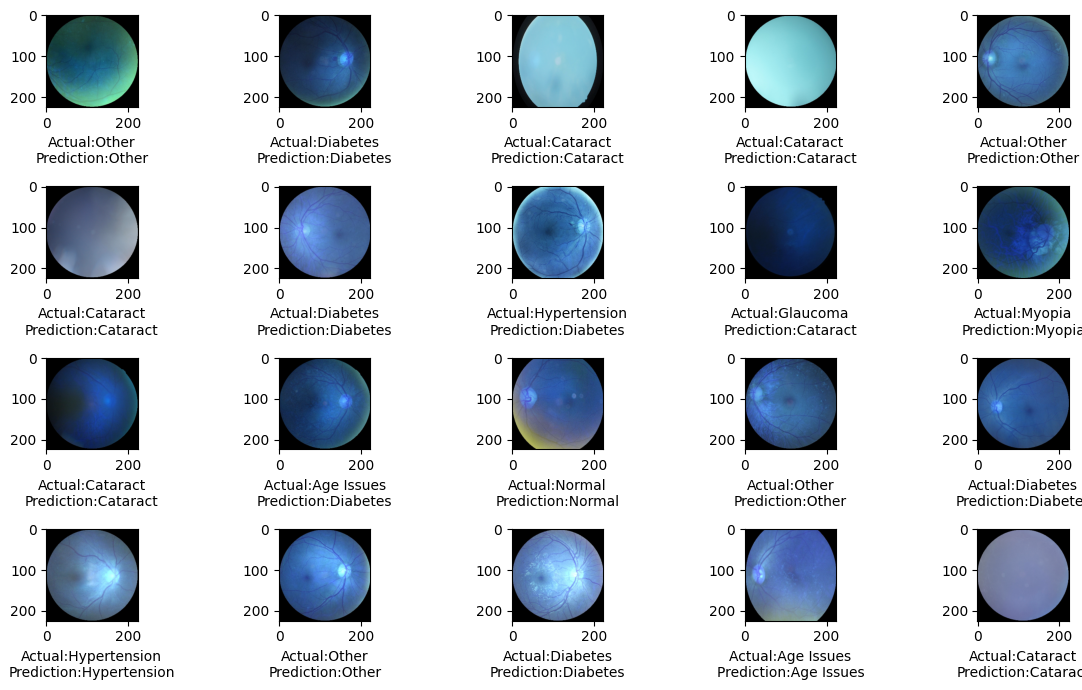

In [39]:
plt.figure(figsize=(12,7))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"

    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Age Issues"
    else:
        pred_label = "Other"

    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

In [68]:
new_image_path = '/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Testing Images/1224_left.jpg'
new_image = cv2.imread(new_image_path)
new_image = cv2.resize(new_image, (224, 224))
new_image = new_image / 255.0

# Perform inference
predictions = model1.predict(np.expand_dims(new_image, axis=0))

# Get the class with the highest probability
predicted_class = np.argmax(predictions)

# Now 'predicted_class' contains the predicted class label for the new image
print(f"Actual: {label}")
print(f"Predicted class: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Actual: Cataract
Predicted class: Cataract


In [66]:
from joblib import dump
dump(model1,"/kaggle/working/eye disease detection.h5")

['/kaggle/working/eye disease detection.h5']